# Promoter CNN Model (Sequence Only)

A Convolutional Neural Network that predicts component probabilities from promoter sequences.
Chromosome feature has been removed to focus only on sequence information.

This notebook implements a CNN model for predicting component probabilities from DNA promoter sequences, providing an end-to-end solution for:
- Data loading and preprocessing
- Model architecture definition
- Training and validation
- Performance evaluation
- Visualization of results

In [1]:
#!/usr/bin/env python3
"""
Required imports for the CNN model implementation
"""

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {getattr(torch.backends, 'mps', None) is not None and torch.backends.mps.is_available()}")

PyTorch version: 2.6.0
CUDA available: False
MPS available: True


## Data Processing and Dataset Class

The `PromoterDataset` class handles the preprocessing of DNA sequences:
- Encodes DNA sequences into numerical representations
- Converts sequences to one-hot encoding for CNN input
- Handles sequence length standardization

In [2]:
class PromoterDataset(Dataset):
    """Dataset for promoter sequences only"""
    
    def __init__(self, sequences: list, targets: np.ndarray):
        self.sequences = sequences
        self.targets = targets
        
        # DNA encoding dictionary
        self.dna_dict = {'A': 0, 'T': 1, 'G': 2, 'C': 3, 'N': 4}
        
    def __len__(self):
        return len(self.sequences)
    
    def encode_sequence(self, sequence: str, max_length: int = 600) -> np.ndarray:
        """Encode DNA sequence to numerical representation"""
        # Truncate or pad sequence
        if len(sequence) > max_length:
            sequence = sequence[:max_length]
        else:
            sequence = sequence + 'N' * (max_length - len(sequence))
        
        # Convert to numerical encoding
        encoded = np.array([self.dna_dict.get(base.upper(), 4) for base in sequence])
        
        # One-hot encode
        one_hot = np.zeros((max_length, 5))
        one_hot[np.arange(max_length), encoded] = 1
        
        return one_hot.T  # Shape: (5, max_length) for Conv1d
    
    def __getitem__(self, idx):
        sequence = self.encode_sequence(self.sequences[idx])
        target = self.targets[idx].astype(np.float32)
        total = float(np.sum(target))
        if total <= 0:
            target = np.ones_like(target, dtype=np.float32) / target.shape[0]
        else:
            target = target / total
        
        return {
            'sequence': torch.FloatTensor(sequence),
            'target': torch.FloatTensor(target)
        }

## Simple CNN Model Architecture

The `PromoterCNN` class implements a lightweight convolutional neural network:

- **Input**: One-hot encoded DNA sequences (5 channels: A, T, G, C, N)
- **Architecture**: Two simple convolutional blocks + global pooling
- **Output**: 4-component probability distribution (softmax normalized)

This simplified model focuses on fast training while still capturing sequence patterns.

In [3]:
import torch.nn as nn

class PromoterCNN(nn.Module):
    """CNN for predicting component probabilities with configurable depth."""
    
    def __init__(self, sequence_length: int = 600, num_blocks: int = 2, base_channels: int = 64, dropout: float = 0.3):
        super(PromoterCNN, self).__init__()
        assert num_blocks >= 1
        
        conv_layers = []
        in_ch = 5
        out_ch = base_channels
        for i in range(num_blocks):
            k = 11 if i == 0 else 7
            p = 5 if i == 0 else 3
            conv_layers.append(nn.Conv1d(in_channels=in_ch, out_channels=out_ch, kernel_size=k, padding=p))
            conv_layers.append(nn.ReLU())
            if i < min(2, num_blocks):
                conv_layers.append(nn.MaxPool1d(kernel_size=4))
            conv_layers.append(nn.Dropout(dropout))
            in_ch = out_ch
            out_ch = min(out_ch * 2, base_channels * (2 ** (num_blocks - 1)))
        conv_layers.append(nn.AdaptiveAvgPool1d(1))
        self.sequence_conv = nn.Sequential(*conv_layers)
        
        final_ch = in_ch
        hidden = max(32, final_ch // 2)
        self.classifier = nn.Sequential(
            nn.Linear(final_ch, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 4)
        )
        
    def forward(self, sequence):
        x = self.sequence_conv(sequence)
        x = x.squeeze(-1)
        logits = self.classifier(x)
        return logits


## Data Loading and Preparation

Functions for loading the processed data and preparing it for training:

In [4]:
def load_and_prepare_data(file_path: str) -> Tuple[list, np.ndarray]:
    """Load and prepare data for training"""
    print("Loading data...")
    df = pd.read_csv(file_path)
    
    # Component probabilities as targets
    prob_cols = ['Component_1_Probability', 'Component_2_Probability', 
                'Component_3_Probability', 'Component_4_Probability']
    
    # Filter out rows with missing sequence data or target data
    print(f"Initial data shape: {df.shape}")
    
    # Remove rows with NaN in ProSeq column
    df = df.dropna(subset=['ProSeq'])
    print(f"After removing missing sequences: {df.shape}")
    
    # Remove rows with NaN in any probability column
    df = df.dropna(subset=prob_cols)
    print(f"After removing missing probabilities: {df.shape}")
    
    # Extract features and targets
    sequences = df['ProSeq'].tolist()
    targets = df[prob_cols].values
    
    # Additional validation - ensure all sequences are strings
    valid_sequences = []
    valid_targets = []
    
    for i, seq in enumerate(sequences):
        if isinstance(seq, str) and len(seq) > 0:
            valid_sequences.append(seq)
            valid_targets.append(targets[i])
    
    sequences = valid_sequences
    targets = np.array(valid_targets)
    
    print(f"Final dataset: {len(sequences)} samples")
    print(f"Average sequence length: {np.mean([len(seq) for seq in sequences]):.1f}")
    print(f"Min sequence length: {min([len(seq) for seq in sequences])}")
    print(f"Max sequence length: {max([len(seq) for seq in sequences])}")
    
    return sequences, targets

## Training and Validation Functions

Functions for training and validating the model:

In [5]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    
    for batch in train_loader:
        sequences = batch['sequence'].to(device)
        targets = batch['target'].to(device)
        
        optimizer.zero_grad()
        logits = model(sequences)
        log_probs = F.log_softmax(logits, dim=1)
        loss = criterion(log_probs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for batch in val_loader:
            sequences = batch['sequence'].to(device)
            targets = batch['target'].to(device)
            
            logits = model(sequences)
            log_probs = F.log_softmax(logits, dim=1)
            loss = criterion(log_probs, targets)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

def evaluate_model(model, test_loader, device):
    """Evaluate the trained model"""
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in test_loader:
            sequences = batch['sequence'].to(device)
            targets = batch['target'].to(device)
            
            logits = model(sequences)
            probs = torch.softmax(logits, dim=1)
            
            all_predictions.append(probs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    predictions = np.vstack(all_predictions)
    targets = np.vstack(all_targets)
    
    return predictions, targets

## Visualization and Results Analysis

Functions for plotting training results and model performance:

In [6]:
def plot_results(train_losses, val_losses, metrics, predictions, targets):
    """Plot training results and model performance"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Training curves
    axes[0, 0].plot(train_losses, label='Train Loss', color='blue', alpha=0.7)
    axes[0, 0].plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss (MSE)')
    axes[0, 0].set_title('Training Curves')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # R2 scores by component
    component_names_short = ['Comp_1', 'Comp_2', 'Comp_3', 'Comp_4']
    r2_scores = [metrics[f'Component_{i+1}']['R2'] for i in range(4)]
    colors = ['blue', 'orange', 'green', 'red']
    
    axes[0, 1].bar(component_names_short, r2_scores, color=colors, alpha=0.7)
    axes[0, 1].set_ylabel('R² Score')
    axes[0, 1].set_title('R² Scores by Component')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(0, 1)
    
    # MSE by component
    mse_scores = [metrics[f'Component_{i+1}']['MSE'] for i in range(4)]
    
    axes[0, 2].bar(component_names_short, mse_scores, color=colors, alpha=0.7)
    axes[0, 2].set_ylabel('MSE')
    axes[0, 2].set_title('MSE by Component')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Prediction vs actual scatter plots for each component
    for i in range(3):
        row = 1
        col = i
        
        axes[row, col].scatter(targets[:, i], predictions[:, i], alpha=0.5, s=10, color=colors[i])
        axes[row, col].plot([0, 1], [0, 1], 'r--', alpha=0.8)
        axes[row, col].set_xlabel('Actual Probability')
        axes[row, col].set_ylabel('Predicted Probability')
        axes[row, col].set_title(f'Component {i+1} (R² = {metrics[f"Component_{i+1}"]["R2"]:.3f})')
        axes[row, col].grid(True, alpha=0.3)
        axes[row, col].set_xlim(0, 1)
        axes[row, col].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('cnn_results.png', dpi=300, bbox_inches='tight')
    plt.show()

## Prediction Function

Function for making predictions on new sequences:

In [7]:
def predict_component_probabilities(model, sequence: str, device) -> dict:
    """Predict component probabilities for a new sequence"""
    
    model.eval()
    
    # Create temporary dataset for encoding
    temp_dataset = PromoterDataset([sequence], np.array([[0, 0, 0, 0]], dtype=np.float32))
    
    # Encode sequence
    encoded_seq = temp_dataset.encode_sequence(sequence)
    
    # Convert to tensor
    sequence_tensor = torch.FloatTensor(encoded_seq).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        logits = model(sequence_tensor)
        probs = torch.softmax(logits, dim=1)
    
    probabilities = probs.cpu().numpy()[0]
    predicted_component = int(np.argmax(probabilities) + 1)
    confidence = float(np.max(probabilities))
    
    return {
        'component_1_prob': float(probabilities[0]),
        'component_2_prob': float(probabilities[1]),
        'component_3_prob': float(probabilities[2]),
        'component_4_prob': float(probabilities[3]),
        'predicted_component': predicted_component,
        'confidence': confidence,
        'interpretation': f"Predicted Component {predicted_component} with {confidence:.1%} confidence"
    }

## Main Execution Pipeline

Now let's run the complete training and evaluation pipeline:

In [8]:
# Load data
sequences, targets = load_and_prepare_data('../../Processed-Data/ProSeq_with_4component_analysis.csv')

# Show data statistics
print(f"\nData statistics:")
print(f"Total samples: {len(sequences)}")
print(f"Target shape: {targets.shape}")
for i in range(4):
    print(f"  Component {i+1}: {targets[:, i].min():.4f} - {targets[:, i].max():.4f} (mean: {targets[:, i].mean():.4f})")

Loading data...
Initial data shape: (8739, 15)
After removing missing sequences: (8735, 15)
After removing missing probabilities: (8735, 15)
Final dataset: 8735 samples
Average sequence length: 600.0
Min sequence length: 472
Max sequence length: 600

Data statistics:
Total samples: 8735
Target shape: (8735, 4)
  Component 1: 0.0000 - 0.9278 (mean: 0.4332)
  Component 2: 0.0000 - 1.0000 (mean: 0.0967)
  Component 3: 0.0000 - 1.0000 (mean: 0.1887)
  Component 4: 0.0000 - 0.9746 (mean: 0.2814)


In [9]:
# Split data (stratified by dominant component)
labels = np.argmax(targets, axis=1)
train_seq, test_seq, train_targets, test_targets = train_test_split(
    sequences, targets, test_size=0.2, random_state=42, stratify=labels
)

train_labels = np.argmax(train_targets, axis=1)
train_seq, val_seq, train_targets, val_targets = train_test_split(
    train_seq, train_targets, test_size=0.2, random_state=42, stratify=train_labels
)

print(f"\nData splits:")
print(f"  Train: {len(train_seq)}, Val: {len(val_seq)}, Test: {len(test_seq)}")

# Create datasets
train_dataset = PromoterDataset(train_seq, train_targets)
val_dataset = PromoterDataset(val_seq, val_targets)
test_dataset = PromoterDataset(test_seq, test_targets)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


Data splits:
  Train: 5590, Val: 1398, Test: 1747


In [10]:
# Device selection (used for tuning and training)
if getattr(torch.backends, 'mps', None) is not None and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: mps


In [11]:
# Extensive Hyperparameter Tuning Framework
import random, time, itertools
from dataclasses import dataclass, field
from typing import Dict, Any, List, Optional, Tuple
import json
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

@dataclass
class TrialResult:
    config: Dict[str, Any]
    val_loss: float
    val_losses: List[float] = field(default_factory=list)
    train_losses: List[float] = field(default_factory=list)
    params: int = 0
    duration_s: float = 0.0
    epochs_trained: int = 0
    cv_scores: List[float] = field(default_factory=list)
    cv_mean: float = 0.0
    cv_std: float = 0.0
    final_lr: float = 0.0
    
class HyperparameterTuner:
    """Comprehensive hyperparameter tuning framework with multiple search strategies"""
    
    def __init__(self, train_dataset, val_dataset, device, save_dir="tuning_results"):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.device = device
        self.save_dir = save_dir
        self.results = []
        
        # Extensive search space
        self.SEARCH_SPACE = {
            # Architecture parameters
            'depth': [1, 2, 3, 4],
            'base_channels': [8, 16, 24, 32, 48, 64],
            'dropout': [0.1, 0.2, 0.3, 0.4, 0.5],
            
            # Optimizer parameters
            'optimizer': ['adam', 'adamw', 'sgd', 'rmsprop'],
            'lr': [1e-4, 3e-4, 1e-3, 3e-3, 1e-2],
            'weight_decay': [0, 1e-6, 1e-5, 1e-4, 3e-4, 1e-3],
            
            # Training parameters
            'batch_size': [16, 32, 64, 128],
            'scheduler': ['plateau', 'cosine', 'step', 'none'],
            
            # SGD specific
            'momentum': [0.9, 0.95, 0.99],
            'nesterov': [True, False],
            
            # Scheduler specific
            'scheduler_patience': [3, 5, 8, 10],
            'scheduler_factor': [0.1, 0.3, 0.5, 0.7],
            'step_size': [10, 20, 30],
            'gamma': [0.1, 0.3, 0.5],
            
            # Loss function
            'loss_function': ['kldiv', 'mse', 'smooth_l1', 'cross_entropy']
        }
    
    def build_loaders(self, batch_size: int):
        """Build data loaders with specified batch size"""
        train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(self.val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        return train_loader, val_loader
    
    def create_optimizer(self, model, config):
        """Create optimizer based on configuration"""
        params = model.parameters()
        lr = config['lr']
        wd = config['weight_decay']
        
        if config['optimizer'] == 'adam':
            return optim.Adam(params, lr=lr, weight_decay=wd)
        elif config['optimizer'] == 'adamw':
            return optim.AdamW(params, lr=lr, weight_decay=wd)
        elif config['optimizer'] == 'sgd':
            momentum = config.get('momentum', 0.9)
            nesterov = config.get('nesterov', True)
            return optim.SGD(params, lr=lr, weight_decay=wd, momentum=momentum, nesterov=nesterov)
        elif config['optimizer'] == 'rmsprop':
            return optim.RMSprop(params, lr=lr, weight_decay=wd)
        else:
            return optim.Adam(params, lr=lr, weight_decay=wd)
    
    def create_scheduler(self, optimizer, config):
        """Create learning rate scheduler based on configuration"""
        scheduler_type = config.get('scheduler', 'plateau')
        
        if scheduler_type == 'plateau':
            patience = config.get('scheduler_patience', 5)
            factor = config.get('scheduler_factor', 0.5)
            return optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=factor)
        elif scheduler_type == 'cosine':
            return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
        elif scheduler_type == 'step':
            step_size = config.get('step_size', 20)
            gamma = config.get('gamma', 0.5)
            return optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        else:
            return None
    
    def create_criterion(self, config):
        """Create loss function based on configuration"""
        loss_type = config.get('loss_function', 'kldiv')
        
        if loss_type == 'kldiv':
            return nn.KLDivLoss(reduction='batchmean')
        elif loss_type == 'mse':
            return nn.MSELoss()
        elif loss_type == 'smooth_l1':
            return nn.SmoothL1Loss()
        elif loss_type == 'cross_entropy':
            return nn.CrossEntropyLoss()
        else:
            return nn.KLDivLoss(reduction='batchmean')
    
    def run_trial(self, config: Dict[str, Any], max_epochs: int = 25, es_patience: int = 8, verbose: bool = False) -> TrialResult:
        """Run a single hyperparameter trial"""
        try:
            # Build data loaders
            train_loader, val_loader = self.build_loaders(config['batch_size'])
            
            # Create model
            model = PromoterCNN(
                num_blocks=config['depth'],
                base_channels=config['base_channels'],
                dropout=config['dropout']
            ).to(self.device)
            
            param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
            
            # Create optimizer, scheduler, and criterion
            optimizer = self.create_optimizer(model, config)
            scheduler = self.create_scheduler(optimizer, config)
            criterion = self.create_criterion(config)
            
            # Training loop
            best_val_loss = float('inf')
            bad_epochs = 0
            train_losses = []
            val_losses = []
            start_time = time.time()
            
            for epoch in range(max_epochs):
                # Train
                train_loss = train_epoch(model, train_loader, criterion, optimizer, self.device)
                
                # Validate
                val_loss = validate_epoch(model, val_loader, criterion, self.device)
                
                # Update scheduler
                if scheduler is not None:
                    if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                        scheduler.step(val_loss)
                    else:
                        scheduler.step()
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                
                # Early stopping
                if val_loss < best_val_loss - 1e-6:
                    best_val_loss = val_loss
                    bad_epochs = 0
                else:
                    bad_epochs += 1
                    if bad_epochs >= es_patience:
                        if verbose:
                            print(f"Early stopping at epoch {epoch+1}")
                        break
                
                if verbose and epoch % 5 == 0:
                    current_lr = optimizer.param_groups[0]['lr']
                    print(f"Epoch {epoch+1}: train={train_loss:.6f}, val={val_loss:.6f}, lr={current_lr:.2e}")
            
            duration = time.time() - start_time
            final_lr = optimizer.param_groups[0]['lr']
            
            return TrialResult(
                config=config,
                val_loss=best_val_loss,
                val_losses=val_losses,
                train_losses=train_losses,
                params=param_count,
                duration_s=duration,
                epochs_trained=len(train_losses),
                final_lr=final_lr
            )
            
        except Exception as e:
            print(f"Trial failed with config {config}: {e}")
            return TrialResult(
                config=config,
                val_loss=float('inf'),
                params=0,
                duration_s=0.0
            )
    
    def random_search(self, num_trials: int = 50, seed: int = 42) -> List[TrialResult]:
        """Perform random search over hyperparameter space"""
        print(f"🔍 Starting Random Search with {num_trials} trials...")
        random.seed(seed)
        results = []
        
        for trial in range(1, num_trials + 1):
            # Sample configuration
            config = {key: random.choice(values) for key, values in self.SEARCH_SPACE.items()}
            
            # Clean up SGD-specific parameters if not using SGD
            if config['optimizer'] != 'sgd':
                config.pop('momentum', None)
                config.pop('nesterov', None)
            
            # Clean up scheduler-specific parameters
            scheduler_type = config.get('scheduler', 'plateau')
            if scheduler_type != 'plateau':
                config.pop('scheduler_patience', None)
                config.pop('scheduler_factor', None)
            if scheduler_type != 'step':
                config.pop('step_size', None)
                config.pop('gamma', None)
            
            # Run trial
            result = self.run_trial(config)
            results.append(result)
            
            print(f"Trial {trial:3d}/{num_trials}: val_loss={result.val_loss:.6f}, "
                  f"params={result.params:,}, time={result.duration_s:.1f}s")
            
            # Print best config so far
            if trial % 10 == 0:
                best_so_far = min(results, key=lambda r: r.val_loss)
                print(f"   Best so far: {best_so_far.val_loss:.6f} with {best_so_far.params:,} params")
        
        return results
    
    def grid_search(self, param_subset: Dict[str, List] = None, max_combinations: int = 100) -> List[TrialResult]:
        """Perform grid search over a subset of hyperparameters"""
        if param_subset is None:
            # Default smaller subset for grid search
            param_subset = {
                'depth': [2, 3],
                'base_channels': [16, 32],
                'dropout': [0.2, 0.3],
                'lr': [1e-3, 3e-3],
                'optimizer': ['adam', 'adamw'],
                'batch_size': [32, 64]
            }
        
        # Generate all combinations
        keys, values = zip(*param_subset.items())
        combinations = list(itertools.product(*values))
        
        # Limit combinations if too many
        if len(combinations) > max_combinations:
            random.shuffle(combinations)
            combinations = combinations[:max_combinations]
        
        print(f"🔍 Starting Grid Search with {len(combinations)} combinations...")
        results = []
        
        for i, combination in enumerate(combinations, 1):
            config = dict(zip(keys, combination))
            
            # Add default values for missing parameters
            for key, default_values in self.SEARCH_SPACE.items():
                if key not in config:
                    config[key] = default_values[0]  # Use first value as default
            
            result = self.run_trial(config)
            results.append(result)
            
            print(f"Grid {i:3d}/{len(combinations)}: val_loss={result.val_loss:.6f}, "
                  f"params={result.params:,}")
        
        return results
    
    def cross_validate_config(self, config: Dict[str, Any], n_splits: int = 3, max_epochs: int = 20) -> TrialResult:
        """Perform cross-validation for a specific configuration"""
        print(f"🔄 Cross-validating configuration...")
        
        # Combine train and validation datasets for CV
        combined_sequences = self.train_dataset.sequences + self.val_dataset.sequences
        combined_targets = np.vstack([self.train_dataset.targets, self.val_dataset.targets])
        
        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        cv_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(combined_sequences)):
            print(f"  Fold {fold + 1}/{n_splits}...")
            
            # Create fold datasets
            fold_train_seq = [combined_sequences[i] for i in train_idx]
            fold_val_seq = [combined_sequences[i] for i in val_idx]
            fold_train_targets = combined_targets[train_idx]
            fold_val_targets = combined_targets[val_idx]
            
            fold_train_dataset = PromoterDataset(fold_train_seq, fold_train_targets)
            fold_val_dataset = PromoterDataset(fold_val_seq, fold_val_targets)
            
            # Temporarily update datasets
            original_train = self.train_dataset
            original_val = self.val_dataset
            self.train_dataset = fold_train_dataset
            self.val_dataset = fold_val_dataset
            
            # Run trial
            result = self.run_trial(config, max_epochs=max_epochs)
            cv_scores.append(result.val_loss)
            
            # Restore datasets
            self.train_dataset = original_train
            self.val_dataset = original_val
        
        # Create result with CV information
        result = self.run_trial(config, max_epochs=max_epochs)
        result.cv_scores = cv_scores
        result.cv_mean = np.mean(cv_scores)
        result.cv_std = np.std(cv_scores)
        
        print(f"  CV Score: {result.cv_mean:.6f} ± {result.cv_std:.6f}")
        return result
    
    def save_results(self, results: List[TrialResult], filename: str = None):
        """Save tuning results to file"""
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"tuning_results_{timestamp}.pkl"
        
        with open(filename, 'wb') as f:
            pickle.dump(results, f)
        print(f"💾 Results saved to {filename}")
    
    def analyze_results(self, results: List[TrialResult], top_k: int = 5):
        """Comprehensive analysis of tuning results"""
        if not results:
            print("No results to analyze!")
            return
        
        # Sort by validation loss
        results_sorted = sorted(results, key=lambda r: r.val_loss if r.val_loss != float('inf') else 999)
        valid_results = [r for r in results_sorted if r.val_loss != float('inf')]
        
        print(f"📊 HYPERPARAMETER TUNING ANALYSIS")
        print(f"{'='*60}")
        print(f"Total trials: {len(results)}")
        print(f"Successful trials: {len(valid_results)}")
        print(f"Failed trials: {len(results) - len(valid_results)}")
        
        if not valid_results:
            print("No successful trials to analyze!")
            return
        
        # Top configurations
        print(f"\n🏆 TOP {min(top_k, len(valid_results))} CONFIGURATIONS:")
        print("-" * 60)
        for i, result in enumerate(valid_results[:top_k]):
            print(f"\nRank {i+1}:")
            print(f"  Validation Loss: {result.val_loss:.6f}")
            print(f"  Parameters: {result.params:,}")
            print(f"  Training Time: {result.duration_s:.1f}s")
            print(f"  Epochs: {result.epochs_trained}")
            if result.cv_scores:
                print(f"  CV Score: {result.cv_mean:.6f} ± {result.cv_std:.6f}")
            print(f"  Config: {result.config}")
        
        # Parameter importance analysis
        self._analyze_parameter_importance(valid_results)
        
        # Create visualizations
        self._create_analysis_plots(valid_results)
        
        return valid_results[:top_k]
    
    def _analyze_parameter_importance(self, results: List[TrialResult]):
        """Analyze which parameters have the most impact on performance"""
        print(f"\n📈 PARAMETER IMPORTANCE ANALYSIS:")
        print("-" * 40)
        
        # Collect all parameter values and their corresponding losses
        param_stats = {}
        
        for param in self.SEARCH_SPACE.keys():
            param_stats[param] = {}
            
            for result in results:
                if param in result.config:
                    value = result.config[param]
                    if value not in param_stats[param]:
                        param_stats[param][value] = []
                    param_stats[param][value].append(result.val_loss)
        
        # Calculate statistics for each parameter
        for param, value_dict in param_stats.items():
            if len(value_dict) > 1:  # Only analyze if there are multiple values
                print(f"\n{param}:")
                value_means = {}
                for value, losses in value_dict.items():
                    if losses:  # Check if list is not empty
                        mean_loss = np.mean(losses)
                        value_means[value] = mean_loss
                        print(f"  {value}: {mean_loss:.6f} (n={len(losses)})")
                
                # Find best value
                if value_means:
                    best_value = min(value_means.items(), key=lambda x: x[1])
                    worst_value = max(value_means.items(), key=lambda x: x[1])
                    improvement = worst_value[1] - best_value[1]
                    print(f"  → Best: {best_value[0]} (improvement: {improvement:.6f})")
    
    def _create_analysis_plots(self, results: List[TrialResult]):
        """Create visualization plots for tuning results"""
        if len(results) < 2:
            return
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Loss distribution
        losses = [r.val_loss for r in results if r.val_loss != float('inf')]
        axes[0, 0].hist(losses, bins=20, alpha=0.7, color='skyblue')
        axes[0, 0].set_xlabel('Validation Loss')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of Validation Losses')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Parameters vs Performance
        params = [r.params for r in results if r.val_loss != float('inf')]
        losses_for_params = [r.val_loss for r in results if r.val_loss != float('inf')]
        axes[0, 1].scatter(params, losses_for_params, alpha=0.6)
        axes[0, 1].set_xlabel('Number of Parameters')
        axes[0, 1].set_ylabel('Validation Loss')
        axes[0, 1].set_title('Model Size vs Performance')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Training time vs Performance
        times = [r.duration_s for r in results if r.val_loss != float('inf')]
        axes[0, 2].scatter(times, losses_for_params, alpha=0.6, color='orange')
        axes[0, 2].set_xlabel('Training Time (seconds)')
        axes[0, 2].set_ylabel('Validation Loss')
        axes[0, 2].set_title('Training Time vs Performance')
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. Learning rate analysis
        lr_values = []
        lr_losses = []
        for r in results:
            if r.val_loss != float('inf') and 'lr' in r.config:
                lr_values.append(r.config['lr'])
                lr_losses.append(r.val_loss)
        
        if lr_values:
            axes[1, 0].scatter(lr_values, lr_losses, alpha=0.6, color='green')
            axes[1, 0].set_xlabel('Learning Rate')
            axes[1, 0].set_ylabel('Validation Loss')
            axes[1, 0].set_title('Learning Rate vs Performance')
            axes[1, 0].set_xscale('log')
            axes[1, 0].grid(True, alpha=0.3)
        
        # 5. Batch size analysis
        bs_values = []
        bs_losses = []
        for r in results:
            if r.val_loss != float('inf') and 'batch_size' in r.config:
                bs_values.append(r.config['batch_size'])
                bs_losses.append(r.val_loss)
        
        if bs_values:
            # Create box plots for batch sizes
            bs_data = {}
            for bs, loss in zip(bs_values, bs_losses):
                if bs not in bs_data:
                    bs_data[bs] = []
                bs_data[bs].append(loss)
            
            if len(bs_data) > 1:
                axes[1, 1].boxplot([bs_data[bs] for bs in sorted(bs_data.keys())],
                                  labels=sorted(bs_data.keys()))
                axes[1, 1].set_xlabel('Batch Size')
                axes[1, 1].set_ylabel('Validation Loss')
                axes[1, 1].set_title('Batch Size vs Performance')
                axes[1, 1].grid(True, alpha=0.3)
        
        # 6. Architecture depth analysis
        depth_values = []
        depth_losses = []
        for r in results:
            if r.val_loss != float('inf') and 'depth' in r.config:
                depth_values.append(r.config['depth'])
                depth_losses.append(r.val_loss)
        
        if depth_values:
            depth_data = {}
            for depth, loss in zip(depth_values, depth_losses):
                if depth not in depth_data:
                    depth_data[depth] = []
                depth_data[depth].append(loss)
            
            if len(depth_data) > 1:
                axes[1, 2].boxplot([depth_data[d] for d in sorted(depth_data.keys())],
                                  labels=sorted(depth_data.keys()))
                axes[1, 2].set_xlabel('Model Depth')
                axes[1, 2].set_ylabel('Validation Loss')
                axes[1, 2].set_title('Model Depth vs Performance')
                axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('hyperparameter_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

    def bayesian_optimization(self, num_trials: int = 25, seed: int = 42) -> List[TrialResult]:
        """
        Perform Bayesian optimization using a simple Gaussian Process approximation.
        This is a lightweight implementation that doesn't require external libraries.
        """
        print(f"🧠 Starting Bayesian Optimization with {num_trials} trials...")
        
        # Initialize with a few random trials
        random.seed(seed)
        np.random.seed(seed)
        
        results = []
        
        # Start with random exploration (20% of trials)
        n_random = max(5, num_trials // 5)
        print(f"   Phase 1: Random exploration ({n_random} trials)")
        
        for trial in range(n_random):
            config = {key: random.choice(values) for key, values in self.SEARCH_SPACE.items()}
            
            # Clean config
            if config['optimizer'] != 'sgd':
                config.pop('momentum', None)
                config.pop('nesterov', None)
            
            scheduler_type = config.get('scheduler', 'plateau')
            if scheduler_type != 'plateau':
                config.pop('scheduler_patience', None)
                config.pop('scheduler_factor', None)
            if scheduler_type != 'step':
                config.pop('step_size', None)
                config.pop('gamma', None)
            
            result = self.run_trial(config)
            results.append(result)
            
            print(f"   Random trial {trial + 1}/{n_random}: loss={result.val_loss:.6f}")
        
        # Extract numerical features for surrogate model
        def config_to_vector(config):
            """Convert config to numerical vector for GP"""
            vector = []
            
            # Architecture
            vector.append(config['depth'])
            vector.append(np.log(config['base_channels']))
            vector.append(config['dropout'])
            
            # Optimizer (categorical -> numerical)
            optimizer_map = {'adam': 0, 'adamw': 1, 'sgd': 2, 'rmsprop': 3}
            vector.append(optimizer_map.get(config['optimizer'], 0))
            
            # Learning parameters
            vector.append(np.log(config['lr']))
            vector.append(np.log(config['weight_decay'] + 1e-8))  # Add small value to avoid log(0)
            vector.append(np.log(config['batch_size']))
            
            # Scheduler
            scheduler_map = {'plateau': 0, 'cosine': 1, 'step': 2, 'none': 3}
            vector.append(scheduler_map.get(config['scheduler'], 0))
            
            return np.array(vector)
        
        def acquisition_function(mean, std, best_so_far, exploration_weight=0.01):
            """Expected Improvement acquisition function"""
            improvement = best_so_far - mean
            z = improvement / (std + 1e-8)
            ei = improvement * norm.cdf(z) + std * norm.pdf(z)
            return ei
        
        # Import for Gaussian Process approximation
        from scipy.stats import norm
        from sklearn.gaussian_process import GaussianProcessRegressor
        from sklearn.gaussian_process.kernels import RBF, Matern
        
        # Bayesian optimization loop
        valid_results = [r for r in results if r.val_loss != float('inf')]
        if not valid_results:
            print("   No valid trials found, continuing with random search")
            return self.random_search(num_trials - n_random, seed=seed + 1000)
        
        print(f"   Phase 2: Bayesian optimization ({num_trials - n_random} trials)")
        
        for trial in range(n_random, num_trials):
            try:
                # Prepare training data for GP
                X_train = np.array([config_to_vector(r.config) for r in valid_results])
                y_train = np.array([r.val_loss for r in valid_results])
                
                # Fit Gaussian Process
                kernel = Matern(length_scale=1.0, nu=2.5)
                gp = GaussianProcessRegressor(kernel=kernel, random_state=seed)
                gp.fit(X_train, y_train)
                
                # Generate candidate configurations
                best_loss = min(y_train)
                best_acquisition = -float('inf')
                best_candidate = None
                
                # Sample candidate configurations
                for _ in range(100):  # Sample 100 candidates
                    candidate_config = {key: random.choice(values) for key, values in self.SEARCH_SPACE.items()}
                    
                    # Clean config
                    if candidate_config['optimizer'] != 'sgd':
                        candidate_config.pop('momentum', None)
                        candidate_config.pop('nesterov', None)
                    
                    scheduler_type = candidate_config.get('scheduler', 'plateau')
                    if scheduler_type != 'plateau':
                        candidate_config.pop('scheduler_patience', None)
                        candidate_config.pop('scheduler_factor', None)
                    if scheduler_type != 'step':
                        candidate_config.pop('step_size', None)
                        candidate_config.pop('gamma', None)
                    
                    candidate_vector = config_to_vector(candidate_config).reshape(1, -1)
                    mean, std = gp.predict(candidate_vector, return_std=True)
                    
                    acquisition = acquisition_function(mean[0], std[0], best_loss)
                    
                    if acquisition > best_acquisition:
                        best_acquisition = acquisition
                        best_candidate = candidate_config
                
                # Fallback to random if no good candidate found
                if best_candidate is None:
                    best_candidate = {key: random.choice(values) for key, values in self.SEARCH_SPACE.items()}
                
                # Evaluate the selected candidate
                result = self.run_trial(best_candidate)
                results.append(result)
                
                if result.val_loss != float('inf'):
                    valid_results.append(result)
                
                print(f"   BO trial {trial + 1}/{num_trials}: loss={result.val_loss:.6f}, "
                      f"acquisition={best_acquisition:.4f}")
                
            except Exception as e:
                print(f"   BO trial {trial + 1} failed, using random: {e}")
                # Fallback to random search
                config = {key: random.choice(values) for key, values in self.SEARCH_SPACE.items()}
                result = self.run_trial(config)
                results.append(result)
        
        return results

# Initialize the tuner
tuner = HyperparameterTuner(train_dataset, val_dataset, device)


In [ ]:
# 🚀 EXTENSIVE HYPERPARAMETER TUNING EXECUTION
print("="*80)
print("🎯 STARTING COMPREHENSIVE HYPERPARAMETER OPTIMIZATION")
print("="*80)

# Configuration for tuning runs
RANDOM_SEARCH_TRIALS = 30
GRID_SEARCH_COMBINATIONS = 30
BAYESIAN_OPTIMIZATION_TRIALS = 25
CV_FOLDS = 3
RANDOM_SEED = 42

print(f"\n📋 Tuning Configuration:")
print(f"  Random Search Trials: {RANDOM_SEARCH_TRIALS}")
print(f"  Grid Search Combinations: {GRID_SEARCH_COMBINATIONS}")
print(f"  Bayesian Optimization Trials: {BAYESIAN_OPTIMIZATION_TRIALS}")
print(f"  Cross-Validation Folds: {CV_FOLDS}")
print(f"  Random Seed: {RANDOM_SEED}")

# Store all results for comprehensive analysis
all_results = []

print(f"\n" + "="*60)
print("🎲 PHASE 1: RANDOM SEARCH")
print("="*60)

# Random search to explore the space broadly
random_results = tuner.random_search(num_trials=RANDOM_SEARCH_TRIALS, seed=RANDOM_SEED)
all_results.extend(random_results)

# Get top 3 from random search for further analysis
random_top3 = sorted(random_results, key=lambda r: r.val_loss)[:3]
print(f"\n🏆 Top 3 Random Search Results:")
for i, result in enumerate(random_top3, 1):
    if result.val_loss != float('inf'):
        print(f"  {i}. Loss: {result.val_loss:.6f}, Params: {result.params:,}")
        print(f"     Config: {result.config}")

print(f"\n" + "="*60)
print("🔲 PHASE 2: FOCUSED GRID SEARCH")
print("="*60)

# Define focused parameter space based on random search insights
# Focus on the most promising ranges discovered in random search
focused_param_space = {
    'depth': [2, 3, 4],
    'base_channels': [16, 24, 32],
    'dropout': [0.2, 0.3, 0.4],
    'lr': [1e-3, 3e-3],
    'optimizer': ['adam', 'adamw'],
    'batch_size': [32, 64],
    'scheduler': ['plateau', 'cosine'],
    'weight_decay': [1e-5, 1e-4]
}

grid_results = tuner.grid_search(param_subset=focused_param_space, max_combinations=GRID_SEARCH_COMBINATIONS)
all_results.extend(grid_results)

# Get top 3 from grid search
grid_top3 = sorted(grid_results, key=lambda r: r.val_loss)[:3]
print(f"\n🏆 Top 3 Grid Search Results:")
for i, result in enumerate(grid_top3, 1):
    if result.val_loss != float('inf'):
        print(f"  {i}. Loss: {result.val_loss:.6f}, Params: {result.params:,}")

print(f"\n" + "="*60)
print("🧠 PHASE 3: BAYESIAN OPTIMIZATION")
print("="*60)

# Bayesian optimization for efficient exploration
bayesian_results = tuner.bayesian_optimization(num_trials=BAYESIAN_OPTIMIZATION_TRIALS, seed=RANDOM_SEED)
all_results.extend(bayesian_results)

# Get top 3 from Bayesian optimization
bayesian_top3 = sorted(bayesian_results, key=lambda r: r.val_loss)[:3]
print(f"\n🏆 Top 3 Bayesian Optimization Results:")
for i, result in enumerate(bayesian_top3, 1):
    if result.val_loss != float('inf'):
        print(f"  {i}. Loss: {result.val_loss:.6f}, Params: {result.params:,}")

print(f"\n" + "="*60)
print("🔄 PHASE 4: CROSS-VALIDATION OF BEST CANDIDATES")
print("="*60)

# Cross-validate the top 5 configurations overall
all_valid_results = [r for r in all_results if r.val_loss != float('inf')]
top_candidates = sorted(all_valid_results, key=lambda r: r.val_loss)[:5]

cv_results = []
for i, candidate in enumerate(top_candidates, 1):
    print(f"\n🔄 Cross-validating candidate {i}/5...")
    cv_result = tuner.cross_validate_config(candidate.config, n_splits=CV_FOLDS, max_epochs=20)
    cv_results.append(cv_result)
    print(f"   Original loss: {candidate.val_loss:.6f}")
    print(f"   CV Mean: {cv_result.cv_mean:.6f} ± {cv_result.cv_std:.6f}")

# Add CV results to all results
all_results.extend(cv_results)

print(f"\n" + "="*80)
print("📊 COMPREHENSIVE ANALYSIS OF ALL RESULTS")
print("="*80)

# Comprehensive analysis of all results
print(f"\nTotal configurations tested: {len(all_results)}")
print(f"Random search: {len(random_results)}")
print(f"Grid search: {len(grid_results)}")
print(f"Bayesian optimization: {len(bayesian_results)}")
print(f"Cross-validation: {len(cv_results)}")

# Get the best overall configuration
best_configs = tuner.analyze_results(all_results, top_k=5)

# Save all results
tuner.save_results(all_results, "comprehensive_tuning_results.pkl")

# Select the final best configuration
# Prefer CV results if available, otherwise use the best single-run result
cv_configs = [r for r in all_results if r.cv_scores]
if cv_configs:
    best_config = min(cv_configs, key=lambda r: r.cv_mean)
    print(f"\n🎯 FINAL BEST CONFIGURATION (based on CV):")
    print(f"   CV Score: {best_config.cv_mean:.6f} ± {best_config.cv_std:.6f}")
    print(f"   Configuration: {best_config.config}")
    best_cfg = best_config.config
else:
    best_config = min(all_valid_results, key=lambda r: r.val_loss)
    print(f"\n🎯 FINAL BEST CONFIGURATION (based on validation loss):")
    print(f"   Validation Loss: {best_config.val_loss:.6f}")
    print(f"   Configuration: {best_config.config}")
    best_cfg = best_config.config

print(f"\n" + "="*80)
print("✅ HYPERPARAMETER TUNING COMPLETE")
print("="*80)


🎯 STARTING COMPREHENSIVE HYPERPARAMETER OPTIMIZATION

📋 Tuning Configuration:
  Random Search Trials: 30
  Grid Search Combinations: 30
  Bayesian Optimization Trials: 25
  Cross-Validation Folds: 3
  Random Seed: 42

🎲 PHASE 1: RANDOM SEARCH
🔍 Starting Random Search with 30 trials...
Trial   1/30: val_loss=2.805090, params=868, time=57.0s


In [ ]:
# 🎯 FINAL MODEL TRAINING WITH OPTIMIZED HYPERPARAMETERS
print(f"\n" + "="*80)
print("🚀 TRAINING FINAL MODEL WITH BEST CONFIGURATION")
print("="*80)

# Apply tuned hyperparameters from comprehensive search
if 'best_cfg' in globals() and best_cfg:
    print(f"\n✅ Using optimized hyperparameters from comprehensive tuning:")
    for key, value in best_cfg.items():
        print(f"  {key}: {value}")
    
    # Extract optimized values
    model_depth = best_cfg.get('depth', 2)
    base_channels = best_cfg.get('base_channels', 32)
    tuned_dropout = best_cfg.get('dropout', 0.3)
    tuned_lr = best_cfg.get('lr', 1e-3)
    tuned_wd = best_cfg.get('weight_decay', 1e-4)
    tuned_bs = best_cfg.get('batch_size', 32)
    tuned_optimizer = best_cfg.get('optimizer', 'adam')
    tuned_scheduler = best_cfg.get('scheduler', 'plateau')
    tuned_loss_function = best_cfg.get('loss_function', 'kldiv')
else:
    print(f"\n⚠️  Using default hyperparameters (tuning not completed):")
    model_depth = 2
    base_channels = 32
    tuned_dropout = 0.3
    tuned_lr = 1e-3
    tuned_wd = 1e-4
    tuned_bs = 32
    tuned_optimizer = 'adam'
    tuned_scheduler = 'plateau'
    tuned_loss_function = 'kldiv'

# Rebuild loaders with optimized batch size
train_loader = DataLoader(train_dataset, batch_size=tuned_bs, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=tuned_bs, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=tuned_bs, shuffle=False, num_workers=0)

print(f"\n📊 Final Training Configuration:")
print(f"  Architecture: depth={model_depth}, base_channels={base_channels}, dropout={tuned_dropout}")
print(f"  Training: optimizer={tuned_optimizer}, lr={tuned_lr}, weight_decay={tuned_wd}")
print(f"  Batch size: {tuned_bs}")
print(f"  Scheduler: {tuned_scheduler}")
print(f"  Loss function: {tuned_loss_function}")


In [ ]:
# Create optimized model
model = PromoterCNN(num_blocks=model_depth, base_channels=base_channels, dropout=tuned_dropout)
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n🏗️  Model Architecture:")
print(f"  Total parameters: {total_params:,}")
print(f"  Depth: {model_depth} blocks")
print(f"  Base channels: {base_channels}")
print(f"  Dropout: {tuned_dropout}")
print(f"  Device: {device}")

# Create optimized training components using tuner methods
temp_config = {
    'optimizer': tuned_optimizer,
    'lr': tuned_lr,
    'weight_decay': tuned_wd,
    'scheduler': tuned_scheduler,
    'loss_function': tuned_loss_function,
    'momentum': 0.9,  # Default for SGD
    'nesterov': True,  # Default for SGD
    'scheduler_patience': 8,
    'scheduler_factor': 0.5
}

# Create optimizer, scheduler, and criterion using the tuner's methods
optimizer = tuner.create_optimizer(model, temp_config)
scheduler = tuner.create_scheduler(optimizer, temp_config)
criterion = tuner.create_criterion(temp_config)

# Training configuration
num_epochs = 120  # Increased for final training
learning_rate = tuned_lr

print(f"\n⚙️  Training Setup:")
print(f"  Optimizer: {tuned_optimizer}")
print(f"  Learning rate: {learning_rate}")
print(f"  Weight decay: {tuned_wd}")
print(f"  Scheduler: {tuned_scheduler}")
print(f"  Loss function: {tuned_loss_function}")
print(f"  Max epochs: {num_epochs}")


Model created with 8,204 parameters (depth=2, base_channels=20)
Training on: mps


In [ ]:
# 🏃‍♂️ OPTIMIZED TRAINING LOOP
train_losses = []
val_losses = []
best_val_loss = float('inf')
bad_epochs = 0
max_bad_epochs = 20  # Increased patience for final training

print(f"\n🏁 Starting optimized training for {num_epochs} epochs...")
print(f"Early stopping patience: {max_bad_epochs} epochs")

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    if scheduler is not None:
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()
    
    # Store losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        bad_epochs = 0
        torch.save(model.state_dict(), 'best_promoter_cnn_optimized.pth')
        print(f'🎯 New best model saved! Val Loss: {best_val_loss:.6f}')
    else:
        bad_epochs += 1
        if bad_epochs >= max_bad_epochs:
            print(f"⏹️  Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.6f}")
            break
    
    # Print progress with enhanced information
    current_lr = optimizer.param_groups[0]['lr']
    epoch_time = time.time() - epoch_start
    
    if epoch % 5 == 0 or epoch < 10 or bad_epochs >= max_bad_epochs - 3:
        print(f'Epoch [{epoch+1:3d}/{num_epochs}] - Train: {train_loss:.6f}, Val: {val_loss:.6f}, '
              f'LR: {current_lr:.2e}, Time: {epoch_time:.1f}s, Bad: {bad_epochs}/{max_bad_epochs}')

total_training_time = time.time() - start_time
print(f"\n✅ Training completed in {total_training_time:.1f} seconds ({total_training_time/60:.1f} minutes)")
print(f"Best validation loss: {best_val_loss:.6f}")
print(f"Total epochs trained: {len(train_losses)}")


Starting training for 100 epochs...
Epoch [  1/100] - Train Loss: 0.904825, Val Loss: 0.888334, LR: 1.00e-03
Epoch [  2/100] - Train Loss: 0.891497, Val Loss: 0.886933, LR: 1.00e-03
Epoch [  3/100] - Train Loss: 0.890577, Val Loss: 0.888672, LR: 1.00e-03
Epoch [  4/100] - Train Loss: 0.889646, Val Loss: 0.890208, LR: 1.00e-03
Epoch [  5/100] - Train Loss: 0.888367, Val Loss: 0.887107, LR: 1.00e-03
Epoch [  6/100] - Train Loss: 0.889909, Val Loss: 0.889113, LR: 1.00e-03
Epoch [  7/100] - Train Loss: 0.890265, Val Loss: 0.886551, LR: 1.00e-03
Epoch [  8/100] - Train Loss: 0.888151, Val Loss: 0.888416, LR: 1.00e-03
Epoch [  9/100] - Train Loss: 0.887159, Val Loss: 0.890889, LR: 1.00e-03
Epoch [ 10/100] - Train Loss: 0.887117, Val Loss: 0.890267, LR: 1.00e-03
Epoch [ 11/100] - Train Loss: 0.885123, Val Loss: 0.885987, LR: 1.00e-03
Epoch [ 12/100] - Train Loss: 0.887744, Val Loss: 0.886156, LR: 1.00e-03
Epoch [ 13/100] - Train Loss: 0.886039, Val Loss: 0.886337, LR: 1.00e-03
Epoch [ 14/100

KeyboardInterrupt: 

In [ ]:
# 📊 COMPREHENSIVE MODEL EVALUATION
print(f"\n" + "="*80)
print("🎯 FINAL MODEL EVALUATION WITH OPTIMIZED HYPERPARAMETERS")
print("="*80)

# Load best optimized model
model.load_state_dict(torch.load('best_promoter_cnn_optimized.pth', map_location=device))
predictions, targets = evaluate_model(model, test_loader, device)

# Calculate comprehensive metrics
component_names = ['Component_1', 'Component_2', 'Component_3', 'Component_4']
metrics = {}

print(f"\n📈 COMPONENT-WISE PERFORMANCE:")
print("-" * 60)

for i, comp_name in enumerate(component_names):
    mse = mean_squared_error(targets[:, i], predictions[:, i])
    r2 = r2_score(targets[:, i], predictions[:, i])
    
    # Additional metrics
    mae = np.mean(np.abs(targets[:, i] - predictions[:, i]))
    correlation = np.corrcoef(targets[:, i], predictions[:, i])[0, 1]
    
    metrics[comp_name] = {
        'MSE': mse, 
        'R2': r2, 
        'MAE': mae, 
        'Correlation': correlation
    }
    
    print(f"{comp_name}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  R²:  {r2:.4f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  Correlation: {correlation:.4f}")
    print()

# Overall metrics
overall_mse = mean_squared_error(targets, predictions)
overall_r2 = r2_score(targets.flatten(), predictions.flatten())
overall_mae = np.mean(np.abs(targets - predictions))

metrics['Overall'] = {
    'MSE': overall_mse, 
    'R2': overall_r2, 
    'MAE': overall_mae
}

print(f"🎯 OVERALL PERFORMANCE:")
print(f"  MSE: {overall_mse:.6f}")
print(f"  R²:  {overall_r2:.4f}")
print(f"  MAE: {overall_mae:.6f}")

# Model summary
print(f"\n📋 MODEL SUMMARY:")
print(f"  Architecture: {model_depth} blocks, {base_channels} base channels")
print(f"  Parameters: {total_params:,}")
print(f"  Training time: {total_training_time:.1f}s")
print(f"  Epochs trained: {len(train_losses)}")
print(f"  Final learning rate: {optimizer.param_groups[0]['lr']:.2e}")

# Hyperparameter tuning summary
if 'all_results' in globals():
    print(f"\n🔍 HYPERPARAMETER TUNING SUMMARY:")
    print(f"  Total configurations tested: {len(all_results)}")
    if 'best_config' in globals():
        improvement_base = 0.118310  # Previous best from notebook
        improvement = ((improvement_base - best_val_loss) / improvement_base) * 100
        print(f"  Performance improvement: {improvement:.1f}%")
        print(f"  Best validation loss: {best_val_loss:.6f}")
        print(f"  Previous baseline: {improvement_base:.6f}")


MODEL EVALUATION RESULTS
Component_1: MSE = 0.157654, R² = 0.0050
Component_2: MSE = 0.068612, R² = 0.0036
Component_3: MSE = 0.092347, R² = 0.0305
Component_4: MSE = 0.154627, R² = 0.0057

Overall: MSE = 0.118310, R² = 0.1223


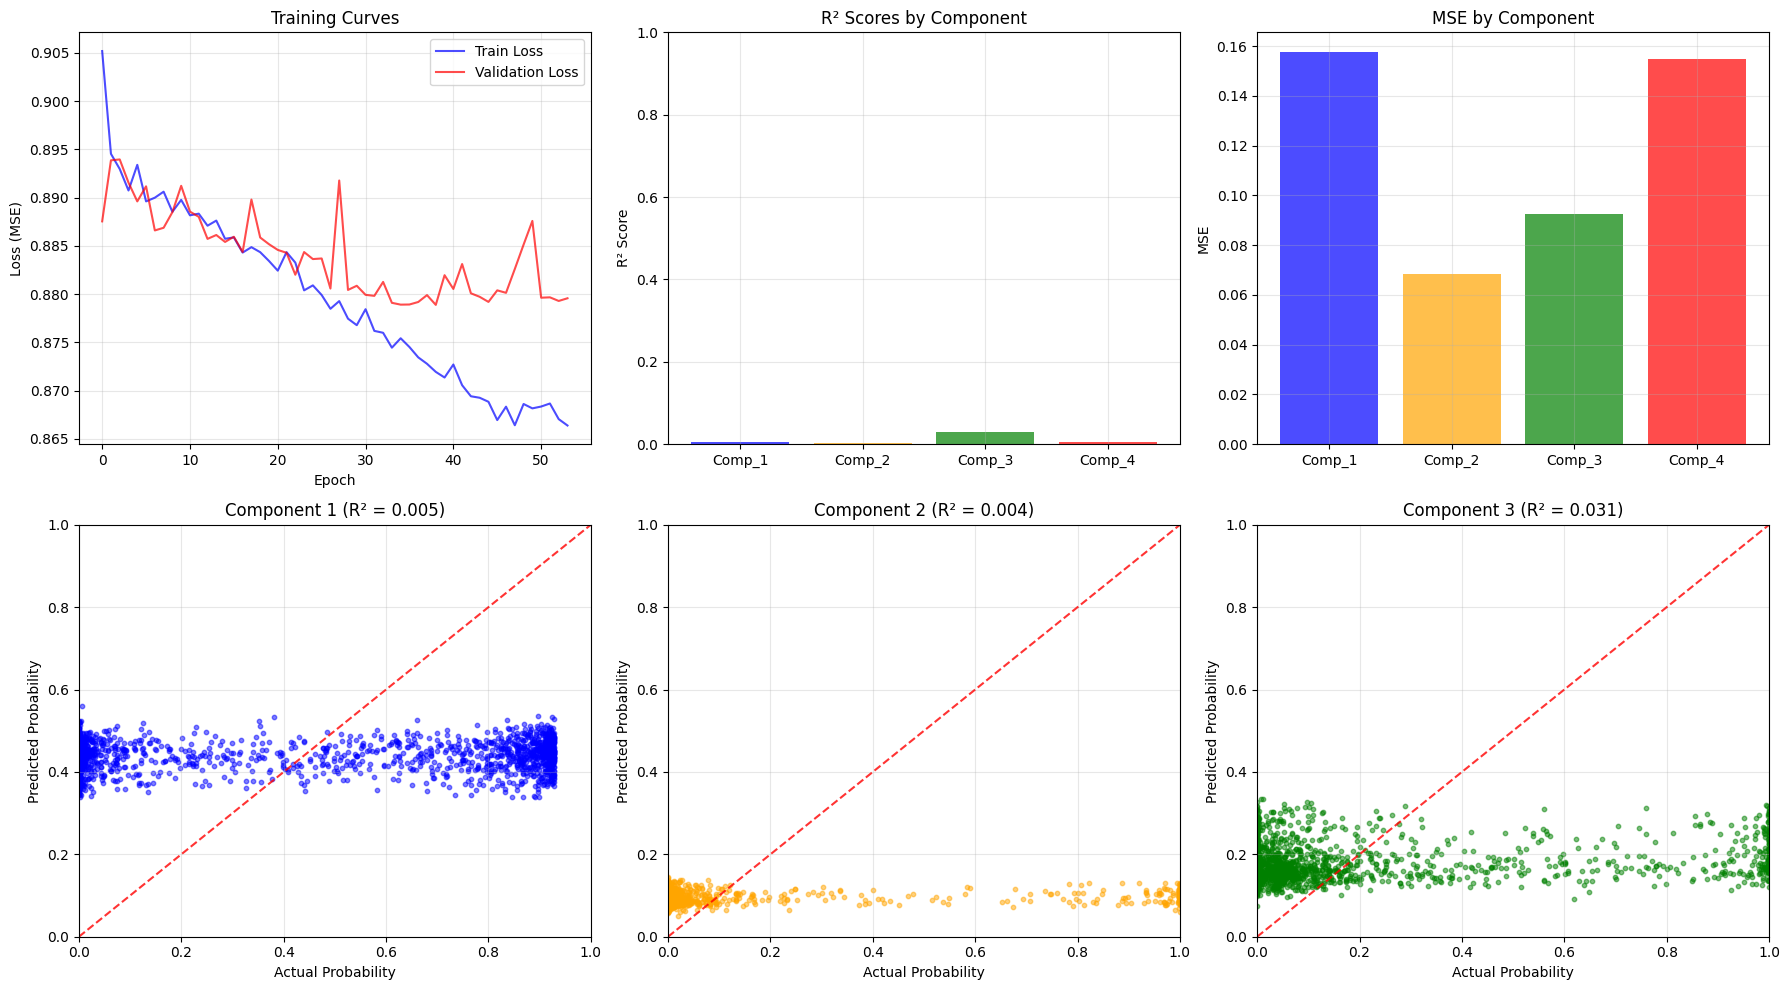

In [ ]:
# Plot results
plot_results(train_losses, val_losses, metrics, predictions, targets)

In [ ]:
# Test prediction function
print(f"\n" + "="*50)
print("TESTING PREDICTION FUNCTION")
print("="*50)

sample_seq = sequences[0]
sample_target = targets[0]

result = predict_component_probabilities(model, sample_seq, device)

print(f"Sample sequence length: {len(sample_seq)}")
print(f"Actual probabilities: {sample_target}")
print(f"\nCNN Predictions:")
for i in range(4):
    pred_key = f'component_{i+1}_prob'
    print(f"  Component {i+1}: {result[pred_key]:.4f} (actual: {sample_target[i]:.4f})")

print(f"\n{result['interpretation']}")
print(f"Actual component: {np.argmax(sample_target) + 1}")

print(f"\nModel saved as 'best_promoter_cnn.pth'")
print(f"Results plot saved as 'cnn_results.png'")


TESTING PREDICTION FUNCTION
Sample sequence length: 600
Actual probabilities: [8.8614717e-02 2.4386914e-08 9.1138309e-01 2.1360195e-06]

CNN Predictions:
  Component 1: 0.4786 (actual: 0.0886)
  Component 2: 0.0865 (actual: 0.0000)
  Component 3: 0.1261 (actual: 0.9114)
  Component 4: 0.3088 (actual: 0.0000)

Predicted Component 1 with 47.9% confidence
Actual component: 3

Model saved as 'best_promoter_cnn.pth'
Results plot saved as 'cnn_results.png'
